In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import imodelsx.linear_finetune
from sasc import analyze_helper
import sasc.viz
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
dvu.set_style()
story_data = joblib.load(join(sasc.config.RESULTS_DIR, 'pilot2_story_data.pkl'))

In [2]:
# load data and corresponding resps
pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230702'
# resp_np_files = sorted(os.listdir(pilot_data_dir))
resp_np_files = ['GenStory9.npy', 'GenStory10.npy']
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
POLYSEMANTIC_STORIES = [2, 3]  # note, story 3 is way better, not sure why
mats = defaultdict(list)
for use_clusters in [False]:
    for story_num in [2, 3]:
        print(story_num, story_data["story_name_new"][story_num])
        rows = story_data["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            story_data["story_name_new"][story_num].replace("_resps", "")
        ].T  # (voxels, time)
        timing = story_data["timing"][story_num]
        # paragraphs = story_data["story_text"][story_num].split("\n\n")
        paragraphs = story_data["paragraphs"][story_num]
        # assert len(paragraphs) == len(rows)
        # print(
        #     "times",
        #     timing["time_running"].max(),
        #     "resp TRs",
        #     resp_story.shape[1],
        #     "doubled",
        #     resp_story.shape[1] * 2,
        # )
        resp_chunks = analyze_helper.get_resp_chunks(
            timing, paragraphs, resp_story, offset=2
        )

        # calculate mat
        mat = np.zeros((len(rows), len(paragraphs)))
        # fill mat with nans
        mat[:] = np.nan

        print(f"{story_num=} {len(rows)=} {len(paragraphs)=} {len(resp_chunks)=}")
        # print(rows['expl1'])

        for i in range(len(paragraphs)):
            if i >= len(resp_chunks):
                mat[:, i] = np.nan
                break
            if use_clusters == False:
                mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(axis=1)
            elif use_clusters == True:
                for r in range(len(rows)):
                    cluster_nums = rows.iloc[r]["cluster_nums"]
                    if isinstance(cluster_nums, np.ndarray):
                        vals = resp_chunks[i][cluster_nums].flatten()
                        mat[r, i] = np.nanmean(vals)
                    else:
                        # print(cluster_nums)
                        mat[r, i] = np.nan
        mat[:, 0] = np.nan  # ignore the first column
        mat[:, -1] = np.nan  # ignore the last column
        # print('mat', mat)

        # sort by voxel_num
        args = np.argsort(rows["voxel_num"].values)
        mat = mat[args, :][:, args]
        # mat = mat[::2]  # only take even rows (since each row is duplicated)
        mats[use_clusters].append(deepcopy(mat))

        # plt.imshow(mat)
        plt.show()
rows = rows.sort_values(by="voxel_num")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(
        mats[use_clusters]
    )  # (num_stories, num_voxels, num_paragraphs)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

2 GenStory9_resps.npy
times 764.539999999996 resp TRs 369 doubled 738
story_num=2 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=13
3 GenStory10_resps.npy
times 682.130000000001 resp TRs 328 doubled 656
story_num=3 len(rows)=16 len(paragraphs)=16 len(resp_chunks)=16


/tmp/ipykernel_1355570/2498551705.py:41: RuntimeWarning: Mean of empty slice.
  mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(axis=1)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_1355570/2498551705.py:72: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### Make average plot

<>:33: DeprecationWarning: invalid escape sequence '\s'
<>:33: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_1355570/849340280.py:33: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


mean 0.16315526937715516
median 0.1801241116343741


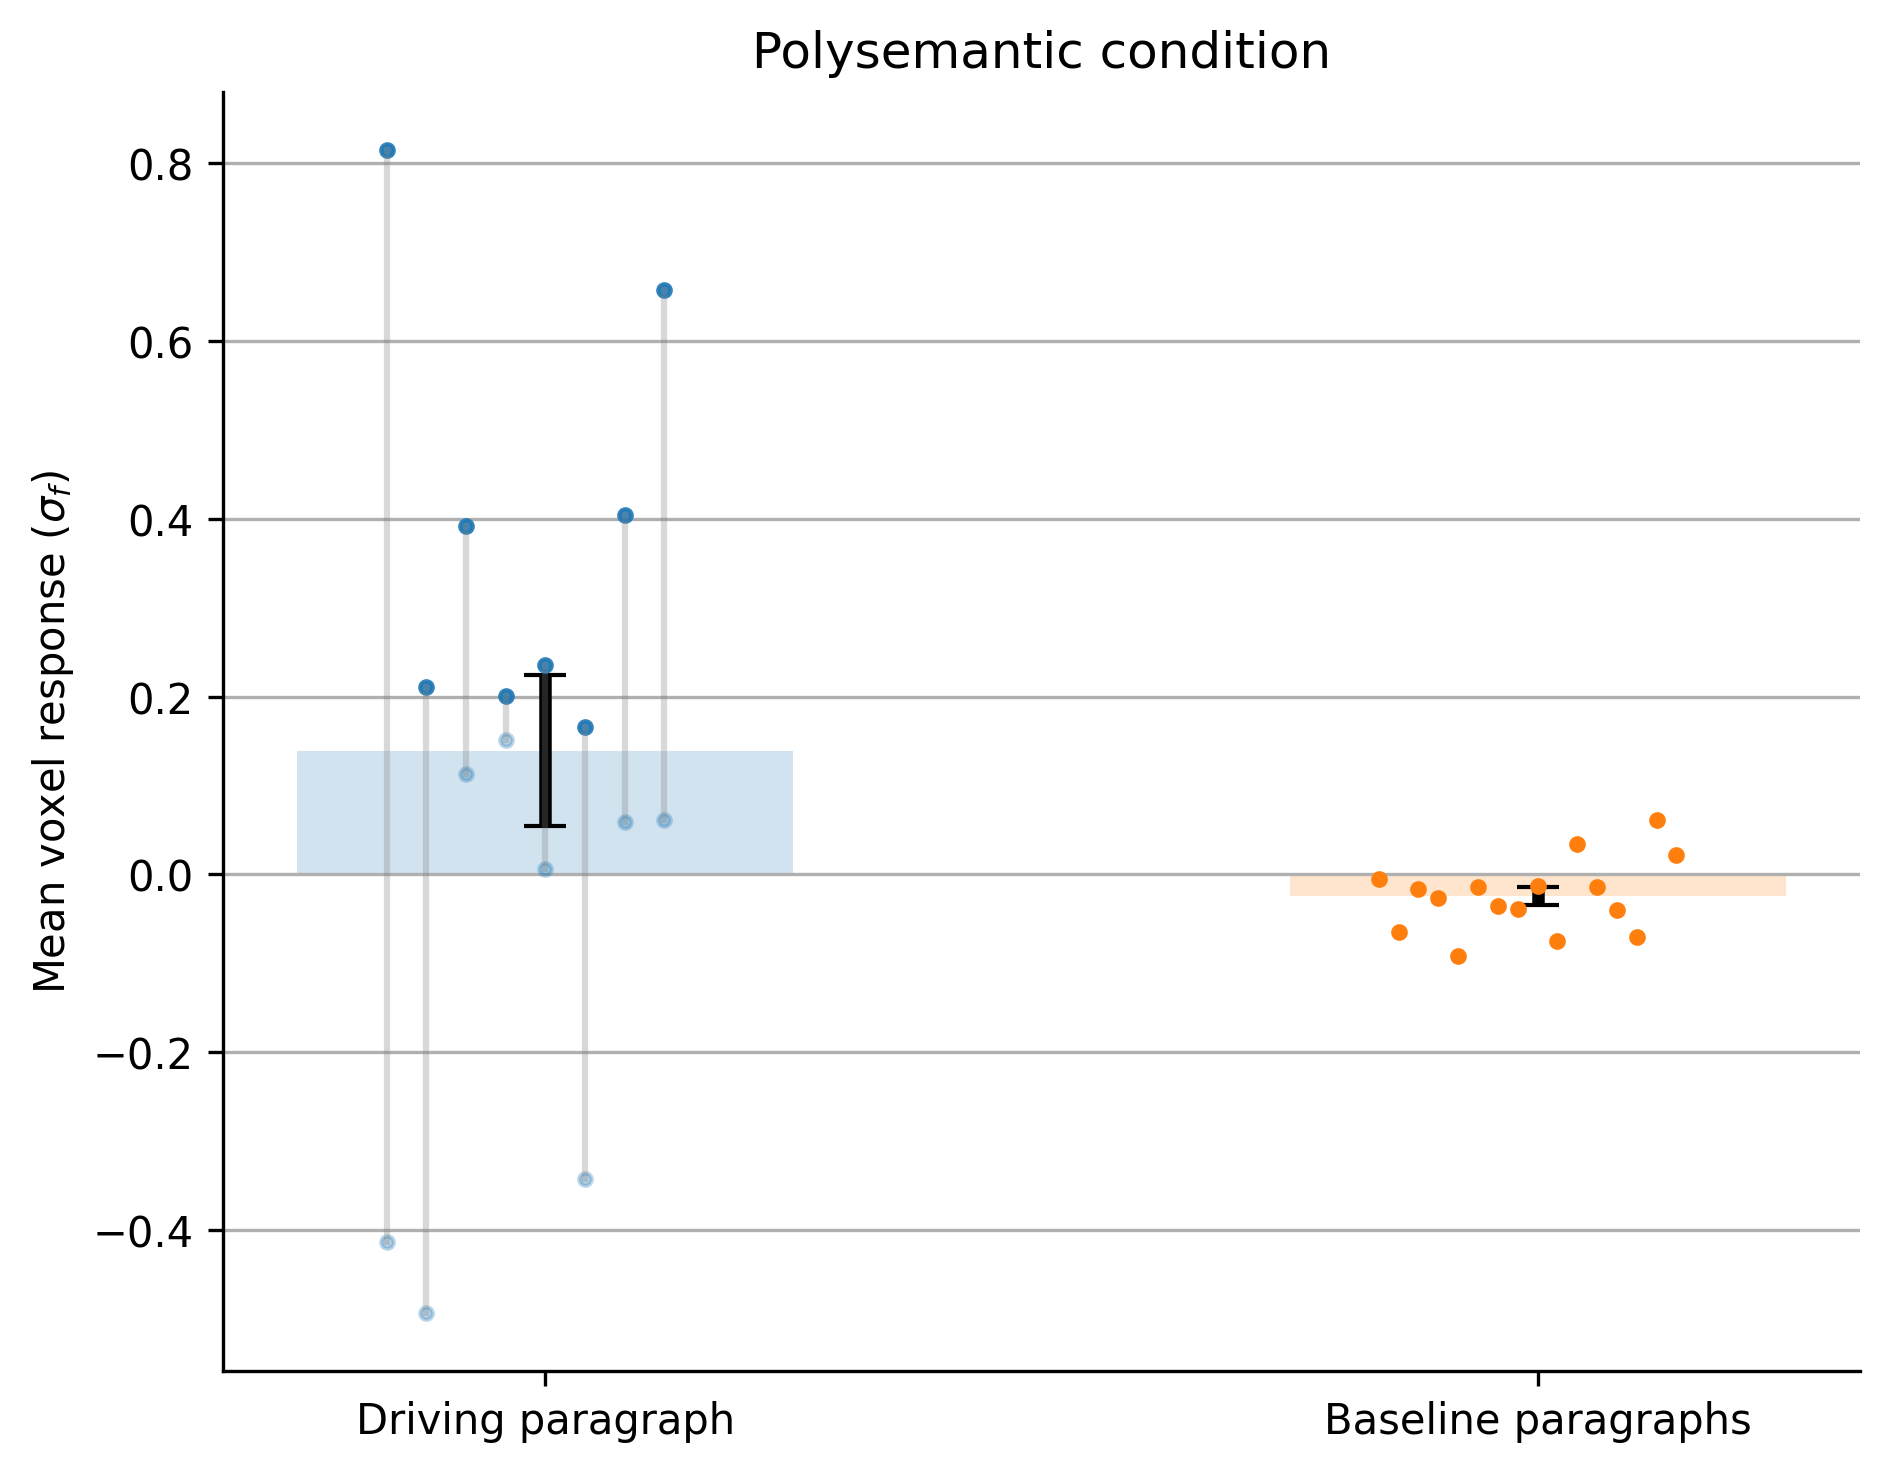

In [ ]:
# calculate means
use_clusters = False
m1 = m[use_clusters]

n = m1.shape[0]
diag_means = np.diag(m1)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)

# make plot
plt.figure(dpi=300)
x = np.arange(n) - n / 2
plt.bar(1, diag_mean, width=0.5, label='Diagonal', alpha=0.2, color='C0')
plt.errorbar(1, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)
# plt.plot(1 + x/50, diag_means, '.', color='C0', alpha=0.5)
for i in range(0, len(diag_means), 2):
    bigger = max(diag_means[i], diag_means[i + 1])
    smaller = min(diag_means[i], diag_means[i + 1])
    plt.plot(1 + (i-n/2)/50, bigger, '.', color='C0', alpha=0.9)
    plt.plot(1 + (i-n/2)/50, smaller, '.', color='C0', alpha=0.3) 
    # draw line between the 2 points
    plt.plot([1 + (i-n/2)/50, 1 + (i-n/2)/50], [bigger, smaller], color='gray', alpha=0.3)


plt.bar(2, off_diag_mean, width=0.5, label='Off-diagonal', alpha=0.2, color='C1')
plt.errorbar(2, off_diag_mean, yerr=np.nanstd(off_diag_means) / np.sqrt(len(off_diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5)
plt.plot(2 + x/50, off_diag_means, '.', color='C1')

plt.xticks([1, 2], ['Driving paragraph', 'Baseline paragraphs'])
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.grid(axis='y')

plt.tight_layout()
print('mean', diag_mean - off_diag_mean)
print('median', np.nanmedian(diag_means) - np.nanmedian(off_diag_means))
plt.title('Polysemantic condition')
# plt.title(f'use_clusters={use_clusters}')
plt.savefig(join(RESULTS_DIR, 'pilot_means.pdf'))

### Relationship between different voxels

In [ ]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]
# cg = sns.clustermap(pd.DataFrame(m, columns=expls, index=expls), method='complete', cmap='viridis', figsize=(10, 10))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.xlabel('Driving paragraph')
plt.figure(figsize=(6, 3), dpi=300)
# m = softmax(m, axis=0)

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=2)

# expls_order = analyze_helper.sort_expls_semantically(expls)
expls_order = np.arange(len(expls))
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
# m_plot = m1
sasc.viz.imshow_diverging(m_plot)
plt.xlabel(
    "Driving paragraph\n(Ideally, diagonal should be brighter)", fontsize="x-small"
)
plt.ylabel("Voxel", fontsize="x-small")
vox_names = []
for i in range(0, len(rows), 2):
    vox_names.append(
        "Vox "
        + str(rows["module_num"].values[i])
        + "\n("
        + rows["expl"].values[i]
        + ' & ' + rows["expl"].values[i + 1]
        + ")"
    )
# plt.yticks(labels=expls_with_num.values[expls_order], ticks=np.arange(len(expls)), fontsize='x-small')
plt.yticks(labels=vox_names, ticks=0.5 + np.arange(len(vox_names)) * 2, fontsize="x-small")
plt.xticks(
    labels=expls[expls_order],
    ticks=np.arange(len(expls)),
    rotation=90,
    fontsize="x-small",
)
plt.show()

# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

In [ ]:
rows["resp_driving"] = np.diag(m[use_clusters])
display(
    rows[["voxel_num", "expl", "roi_anat", "roi_func", "test_corr_new", "resp_driving"]]
    .sort_values(by="resp_driving", ascending=False)
    .round(2)
)
sns.lmplot(data=rows, x="test_corr_new", y="resp_driving")
plt.ylabel("Mean voxel response ($\sigma_f$), driving paragraphs")
plt.xlabel("Encoding performance (corr.) on new data")
plt.show()

### Story-level differences

In [ ]:
use_clusters = False
mats1 = mats[use_clusters]

d = defaultdict(list)
STORY_NUMS = [2, 3]
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(story_data['story_name_new'][STORY_NUMS[i]][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=['driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
plt.figure(dpi=300)
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.show()